In [67]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

# Load Data

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
train_transforms = transforms.Compose([
	transforms.ToTensor(), 
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
	transforms.RandomHorizontalFlip(p=0.5)
])

test_transforms = transforms.Compose([
	transforms.ToTensor(), 
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_data = CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

BATCH_SIZE = 4

# Dataloaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

classes = ['plane', 'car', 'bird', 'cat', 
		   'deer', 'dog', 'frog', 'horse', 'ship', 
		   'truck']

Files already downloaded and verified
Files already downloaded and verified


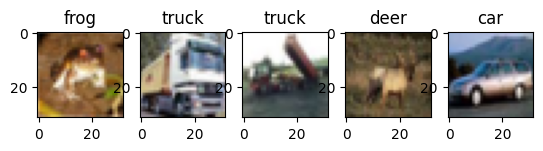

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize some images
fig = plt.figure()
for i in range(5):
	img = train_loader.dataset[i][0]
	img = img.numpy()
	img = np.transpose(img, (1, 2, 0))
	# unnormalize
	img = img * 0.5 + 0.5
	ax = fig.add_subplot(1, 5, i+1)
	ax.imshow(img)
	ax.set_title(classes[train_loader.dataset[i][1]])

In [70]:
# Create Model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
	def __init__(self):
		super(CNN, self).__init__()
		self.seq1 = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(2, 2),
			nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(2, 2),
			nn.Flatten()
		)

		n_channels = self.seq1(torch.empty(1, 3, 32, 32)).view(1, -1).shape[-1]
		print(n_channels)

		self.seq2 = nn.Sequential(
			nn.Linear(n_channels, 120),
			nn.ReLU(),
			nn.Linear(120, 84),
			nn.ReLU(),
			nn.Linear(84, 10),
		)

	def forward(self, x):
		return self.seq2(self.seq1(x))
	
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

400


In [71]:
from tqdm import tqdm

def train(epoch, loss_vals):
	running_loss = 0.0
	model.train()
	loop = tqdm(train_loader, leave=False, desc=f"Epoch {epoch}")
	for data, target in loop:
		data, target = data.to(device), target.to(device)
		results = model(data) # Forward pass
		optimizer.zero_grad() # Clear gradients
		loss = loss_fn(results, target) # Calculate loss
		loss.backward() # Backward pass
		optimizer.step() # Update weights
		running_loss += loss.item()
		loop.set_postfix(loss=loss.item())

	loss_vals.append(running_loss / len(train_loader))

def test(loss_vals):
	running_loss = 0.0
	model.eval()
	with torch.inference_mode():
		for data, target in test_loader:
			data, target = data.to(device), target.to(device)
			results = model(data)
			loss = loss_fn(results, target)
			running_loss += loss.item()
			
		loss_vals.append(running_loss / len(test_loader))

In [72]:
train_loss_vals = []
test_loss_vals = []

In [73]:
EPOCHS = 7
for epoch in range(EPOCHS):
	train(epoch, train_loss_vals)
	test(test_loss_vals)

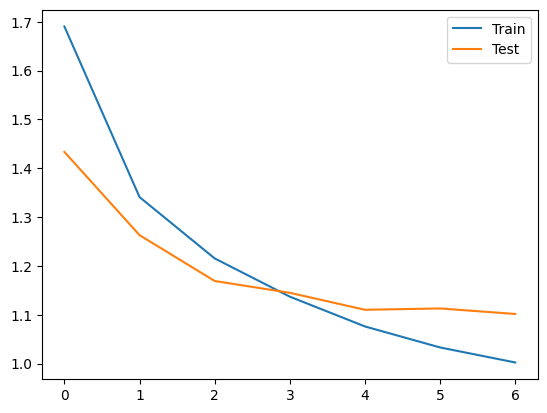

In [75]:
# Plot loss curve]

plt.figure()
plt.plot(range(EPOCHS), train_loss_vals, label='Train')
plt.plot(range(EPOCHS), test_loss_vals, label='Test')
plt.legend()
plt.show()